In [21]:
import torch
import torch.nn as nn
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import scipy.stats as scs
from tqdm import tqdm
from statsmodels.distributions.empirical_distribution import ECDF

In [123]:
class SoftRank(nn.Module):
    """Differentiable ranking layer"""
    def __init__(self, alpha=1000.0):
        super(SoftRank, self).__init__()
        self.alpha = alpha # constant for scaling the sigmoid to approximate sign function, larger values ensure better ranking, overflow is handled properly by PyTorch

    def forward(self, inputs):
        # input is a ?xSxD tensor, we wish to rank the S samples in each dimension per each batch
        # output is  ?xSxD tensor where for each dimension the entries are (rank-0.5)/N_rank
        x = inputs.unsqueeze(-1) #(?,S,D) -> (?,S,D,1)
        x_2 = x.repeat(1, 1, 1, x.shape[1]) # (?,S,D,1) -> (?,S,D,S) (samples are repeated along axis 3, i.e. the last axis)
        x_1 = x_2.transpose(1, 3) #  (?,S,D,S) -> (?,S,D,S) (samples are repeated along axis 1)
        return torch.transpose(torch.sum(torch.sigmoid(self.alpha*(x_1-x_2)), dim=1), 1, 2)/(torch.tensor(x.shape[1], dtype=torch.float32))


class IGC(nn.Module):
    
    def __init__(self, hidden_size=100, layers_number=2, output_size=2):
        super(IGC, self).__init__()
        self.dim_latent = 3 * output_size
        self.hidden_size = hidden_size
        self.layers_nuber = layers_number
        self.output_size = output_size
        self.linear_in = nn.Linear(in_features=self.dim_latent, out_features=self.hidden_size) 
        self.linear = nn.Linear(in_features=self.hidden_size, out_features=self.hidden_size)
        self.linear_out = nn.Linear(in_features=self.hidden_size, out_features=self.output_size)
        self.marginal_cdfs = None
        self.ecdf_10e6_samples = None

    def forward_train(self, z):
        '''
        Input noise z with shape (M,dim_latent)\\
        Outputs (u,v) pairs with shape (M,output_size=2), while ensuring u and v each have uniform marginals.
        '''
        y = torch.relu(self.linear_in(z))
        for layer in range(self.layers_nuber):
            y = torch.relu(self.linear(y))
        y = self.linear_out(y).unsqueeze(0)
        u = SoftRank()(y).squeeze(0)
        return u
        
    def Energy_Score_pytorch(self,beta, observations_y, simulations_Y):
        n = len(observations_y)
        m = len(simulations_Y)

        # First part |Y-y|. Gives the L2 dist scaled by power beta. Is a vector of length n/one value per location.
        diff_Y_y = torch.pow(
            torch.norm(
                (observations_y.unsqueeze(1) -
                simulations_Y.unsqueeze(0)).float(),
                dim=2,keepdim=True).reshape(-1,1),
            beta)

        # Second part |Y-Y'|. 2* because pdist counts only once.
        diff_Y_Y = 2 * torch.pow(
            nn.functional.pdist(simulations_Y),
            beta)
        Energy = 2 * torch.mean(diff_Y_y) - torch.sum(diff_Y_Y) / (m * (m - 1))
        return Energy

    def forward(self, n_samples):
        ''' 
        Function to sample from the copula, once training is done.

        Input: n_samples - number of samples to generate
        Output: torch.tensor of shape (n_samples, output_size) on copula space.
        '''
        with torch.no_grad():
            if self.marginal_cdfs is None:
                self.marginal_cdfs = []
                # sample 10^6 points from the latent space and compute empirical marginal cdfs
                z = torch.randn(10**6, self.dim_latent)
                y = torch.relu(self.linear_in(z))
                for layer in range(self.layers_nuber):
                    y = torch.relu(self.linear(y))
                y = self.linear_out(y) # samples used to approximate cdfs
                for dim in range(y.shape[1]):
                    ecdf = ECDF(y[:, dim].numpy())
                    self.marginal_cdfs.append(ecdf)
                self.ecdf_10e6_samples = y
            # sample the latent space and apply ecdfs
            z = torch.randn(n_samples, self.dim_latent)
            y = torch.relu(self.linear_in(z))
            for layer in range(self.layers_nuber):
                y = torch.relu(self.linear(y))
            y = self.linear_out(y)
            for dim in range(y.shape[1]):
                y[:, dim] = torch.tensor(self.marginal_cdfs[dim](y[:, dim].numpy()), dtype=torch.float32)
            return y



igc_cop = IGC(hidden_size=100, layers_number=2, output_size=2)

igc_cop.forward_train(torch.randn((200, igc_cop.dim_latent))).shape

torch.Size([200, 2])

In [1]:
from IGC_copula import *

100%|██████████| 501/501 [00:03<00:00, 128.42it/s]


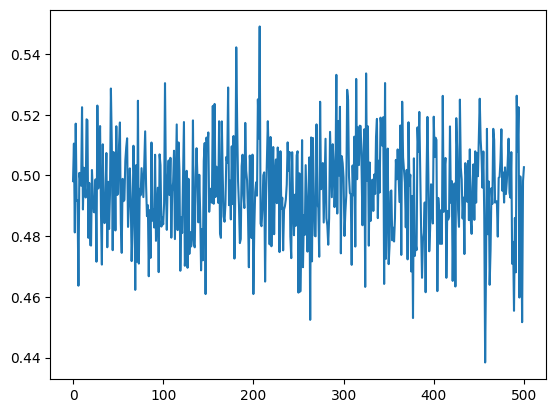

In [2]:
igc_cop = IGC(hidden_size=100, layers_number=2, output_size=2)

z_obs = scs.multivariate_normal.rvs(mean=[0,0], cov=[[1,0.7],[0.7,1]], size=1000)
u1_obs = scs.norm.cdf(z_obs[:,0])
u2_obs = scs.norm.cdf(z_obs[:,1])
u_obs = np.stack([u1_obs, u2_obs], axis=1)
u_obs = torch.tensor(u_obs, dtype=torch.float32)

optimizer = torch.optim.Adam(igc_cop.parameters())
loss_hist = []

for i in tqdm(range(501)):
    optimizer.zero_grad()
    u = igc_cop.forward_train(torch.randn((200, igc_cop.dim_latent)))
    loss = igc_cop.Energy_Score_pytorch(1, u_obs[np.random.choice(range(u_obs.shape[0]),100,replace=True)], u)
    loss.backward()
    optimizer.step()
    loss_hist.append(loss.item())

plt.plot(loss_hist)

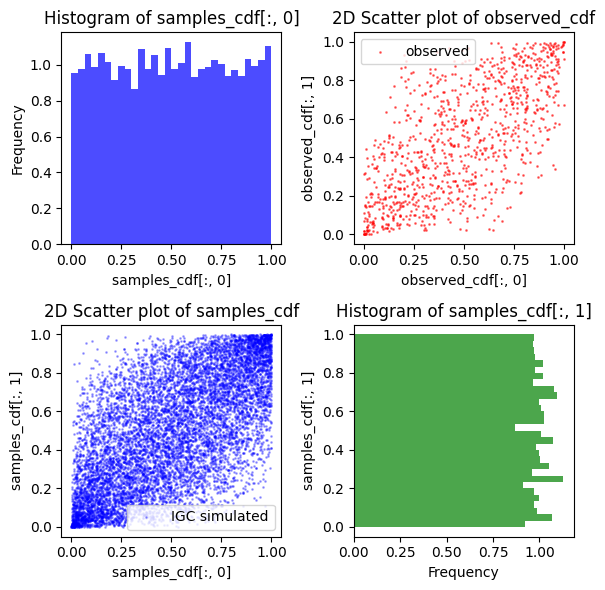

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as scs

# Assuming samples is a 2D array with shape (n_samples, 2)
# and log_pdf_samples is a 1D array with shape (n_samples,)

# Transform samples using the CDF
samples_cdf = igc_cop.forward(10000).detach().numpy()

fig, axs = plt.subplots(2, 2, figsize=(6, 6))

# Subplot [0,0]: Histogram of samples_cdf[:, 0]
axs[0, 0].hist(samples_cdf[:, 0], bins=30, color='blue', alpha=0.7,density=True)
axs[0, 0].set_title('Histogram of samples_cdf[:, 0]')
axs[0, 0].set_xlabel('samples_cdf[:, 0]')
axs[0, 0].set_ylabel('Frequency')

# Subplot [1,1]: Histogram of samples_cdf[:, 1] rotated 90 degrees clockwise
axs[1, 1].hist(samples_cdf[:, 1], bins=30, color='green', alpha=0.7, orientation='horizontal',density=True)
axs[1, 1].set_title('Histogram of samples_cdf[:, 1]')
axs[1, 1].set_xlabel('Frequency')
axs[1, 1].set_ylabel('samples_cdf[:, 1]')

# Subplot [1,0]: 2D scatter plot of samples_cdf with colors based on log_pdf_samples
sc = axs[1, 0].scatter(samples_cdf[:, 0], samples_cdf[:, 1], s=1, c='blue',alpha=0.3, marker='o',label='IGC simulated')
axs[1, 0].set_title('2D Scatter plot of samples_cdf')
axs[1, 0].set_xlabel('samples_cdf[:, 0]')
axs[1, 0].set_ylabel('samples_cdf[:, 1]')
axs[1, 0].legend()
#fig.colorbar(sc, ax=axs[1, 0], label='log_pdf_samples')

# Subplot [0,1]: Trace plot of samples_cdf
sc =axs[0, 1].scatter(u_obs[:,0], u_obs[:,1],label='observed', s=1, c='red',alpha=0.5)
axs[0, 1].set_title('2D Scatter plot of observed_cdf')
axs[0, 1].set_xlabel('observed_cdf[:, 0]')
axs[0, 1].set_ylabel('observed_cdf[:, 1]')
axs[0, 1].legend()

plt.tight_layout()
plt.show()

### 2d Image test

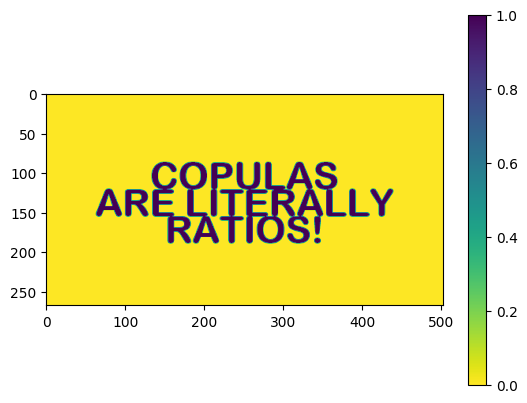

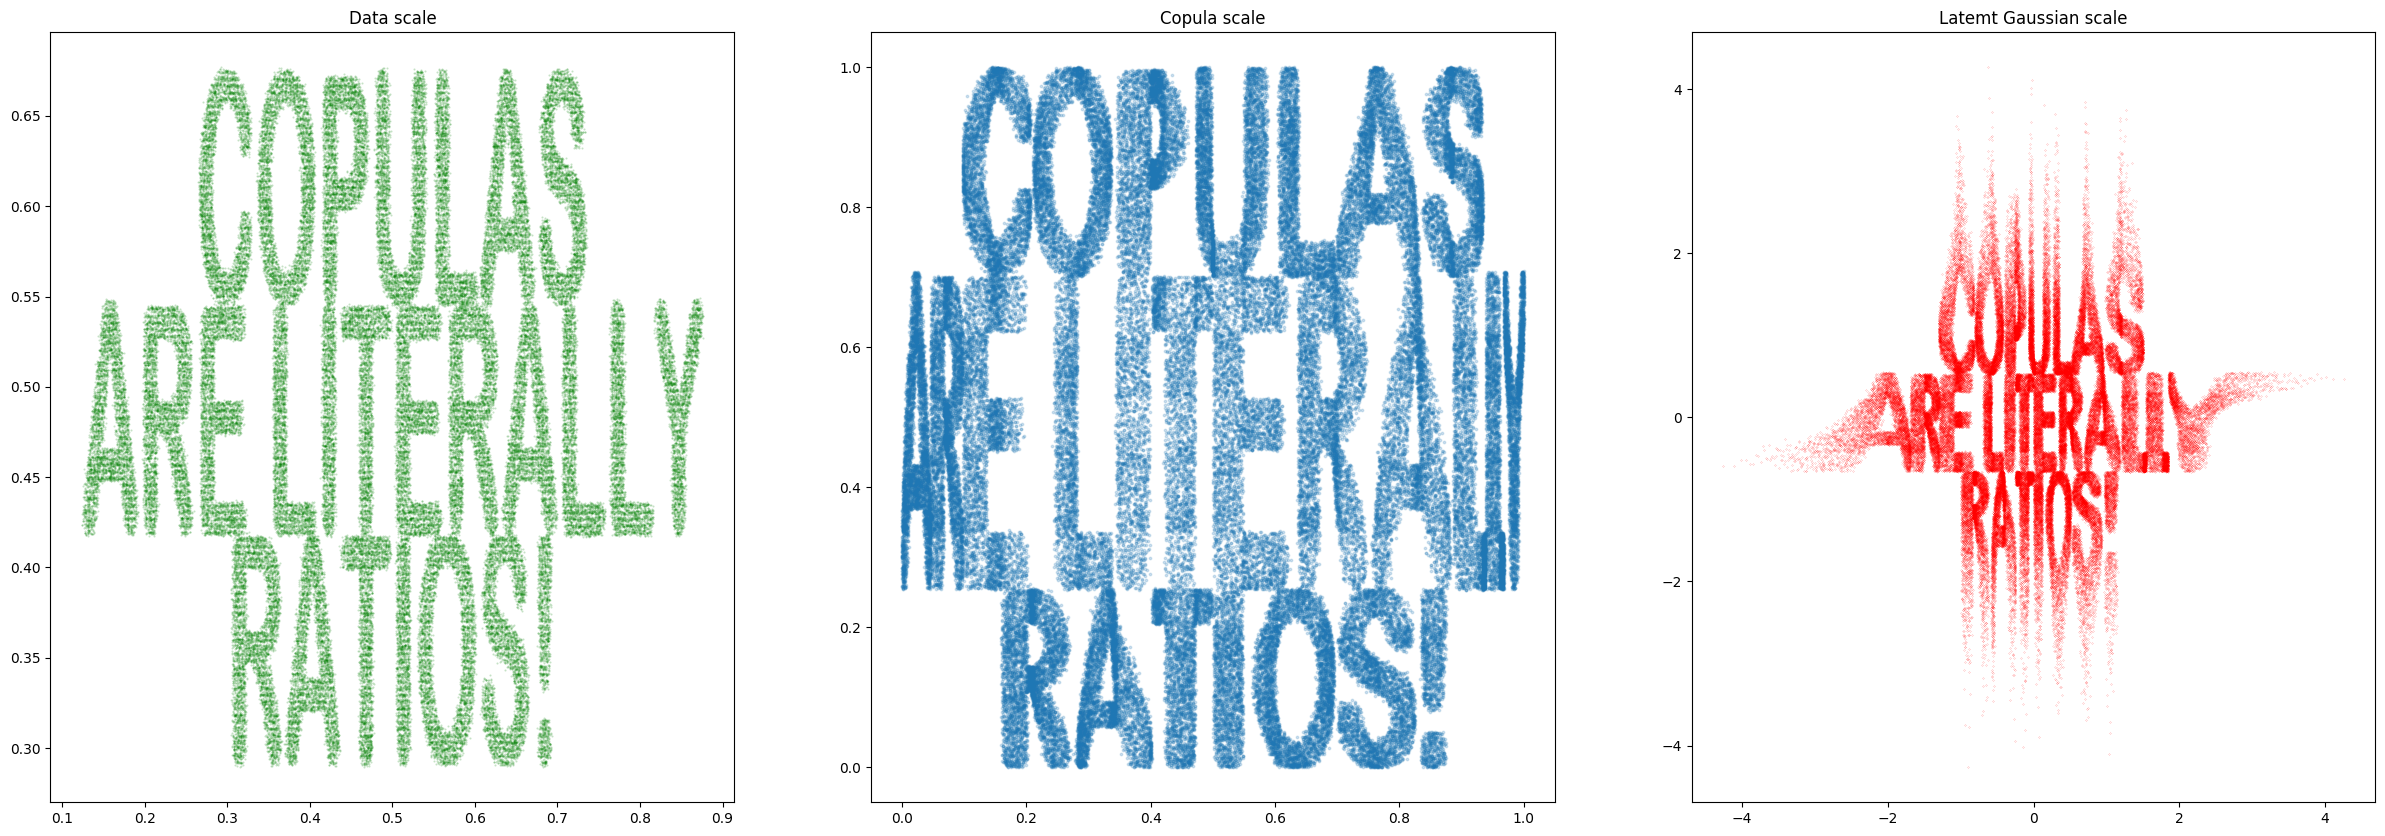

In [137]:
import matplotlib.image as mpimg
import scipy

img=mpimg.imread('copula_equals_ratio.png')#'emily1.jpg')#
# convert to grayscale
img = np.mean(img, axis=2)
img = np.log(1e-2 +img / 6.0)
# rescale to 0,1
img = (img - np.min(img)) / (np.max(img) - np.min(img))
img = np.abs(img - 1.0)
#img = img[:400,:450]
plt.imshow(img, cmap='viridis_r')
plt.colorbar()
img_probs = img/ np.sum(img)
sample_idx = np.random.choice(np.arange(img_probs.flatten().shape[0]), size=100000,  p=img_probs.flatten())
x = np.linspace(0, 1, img.shape[1])
y = np.linspace(1, 0, img.shape[0])
X, Y = np.meshgrid(x, y)
X = X.flatten()
Y = Y.flatten()
X = X[sample_idx]
Y = Y[sample_idx]

'''x_ = np.random.uniform(0.25, 0.75, int(img.shape[1]/5))
y_ = np.random.uniform(0.25, 0.75, int(img.shape[0]/5))
X_, Y_ = np.meshgrid(x_, y_)
X = np.append(X, X_)
Y = np.append(Y, Y_)
'''

data_p = np.stack([X, Y], axis=1) + np.random.normal(0, 0.001, (X.shape[0], 2))

'''# chessboard
data_p1 = np.concatenate((np.random.uniform(0, 1, (5000, 1)), np.random.uniform(0, 1, (5000, 1))), axis=1)
data_p2 = np.concatenate((np.random.uniform(-1, 0, (5000, 1)), np.random.uniform(-1, 0, (5000, 1))), axis=1)
data_p3 = np.concatenate((np.random.uniform(1, 2, (5000, 1)), np.random.uniform(-1, 0, (5000, 1))), axis=1)
data_p4 = np.concatenate((np.random.uniform(-1, 0, (5000, 1)), np.random.uniform(1, 2, (5000, 1))), axis=1)
data_p5 = np.concatenate((np.random.uniform(1, 2, (5000, 1)), np.random.uniform(1, 2, (5000, 1))), axis=1)
#combine the two datasets
data_p = np.concatenate((data_p1, data_p2,data_p3,data_p4,data_p5), axis=0)
'''

from statsmodels.distributions.empirical_distribution import ECDF

cdf_1 = ECDF(data_p[:,0])
cdf_2 = ECDF(data_p[:,1])

from scipy.interpolate import interp1d

slope_changes = sorted(set(data_p[:,0]))

sample_edf_values_at_slope_changes1 = [ cdf_1(item) for item in slope_changes]
sample_edf_values_at_slope_changes2 = [ cdf_2(item) for item in slope_changes]

inverted_cdf1 = interp1d(sample_edf_values_at_slope_changes1, slope_changes)
inverted_cdf2 = interp1d(sample_edf_values_at_slope_changes2, slope_changes)


u = cdf_1(data_p[:,0])
v = cdf_2(data_p[:,1])
u_observed = np.stack([u, v], axis=1)

z1 = scipy.stats.norm.ppf(u)
z2 = scipy.stats.norm.ppf(v)
z = np.stack([z1, z2], axis=1)

# do a 3 subplot
fig, ax = plt.subplots(1,3, figsize=(30,10))
ax[0].scatter(data_p[:,0],data_p[:,1],s=0.3,c='green',alpha=0.2)
ax[1].scatter(u_observed[:,0],u_observed[:,1], s=3, alpha=0.2)
ax[2].scatter(z1,z2, s=0.01, c='red')
# titles for each
ax[0].set_title('Data scale')
ax[1].set_title('Copula scale')
ax[2].set_title('Latemt Gaussian scale')

plt.show()

100%|██████████| 2000/2000 [09:41<00:00,  3.44it/s]


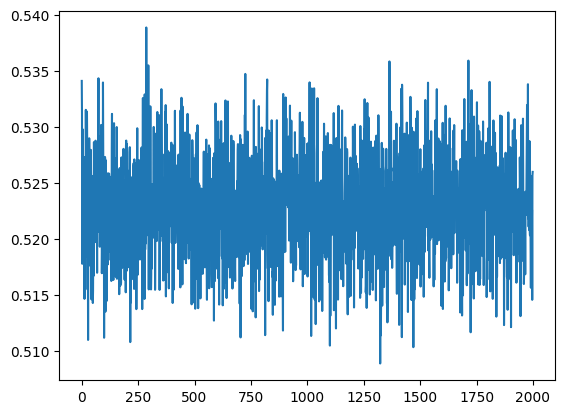

In [166]:
igc_cop = IGC(hidden_size=100, layers_number=5, output_size=2)

u_obs = torch.tensor(u_observed)

optimizer = torch.optim.Adam(igc_cop.parameters())
loss_hist = []

for i in tqdm(range(2000)):
    optimizer.zero_grad()
    u = igc_cop.forward_train(torch.randn((1000, igc_cop.dim_latent)))
    loss = igc_cop.Energy_Score_pytorch(1, u_obs[np.random.choice(range(u_obs.shape[0]),1000,replace=True)], u)
    loss.backward()
    optimizer.step()
    loss_hist.append(loss.item())

plt.plot(loss_hist)

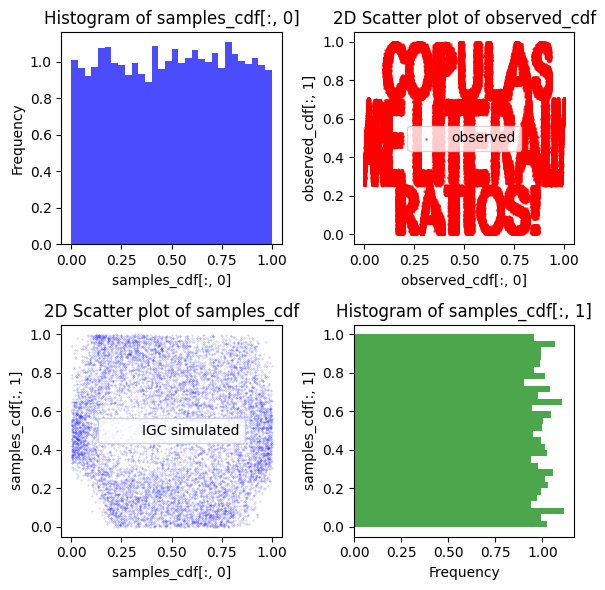

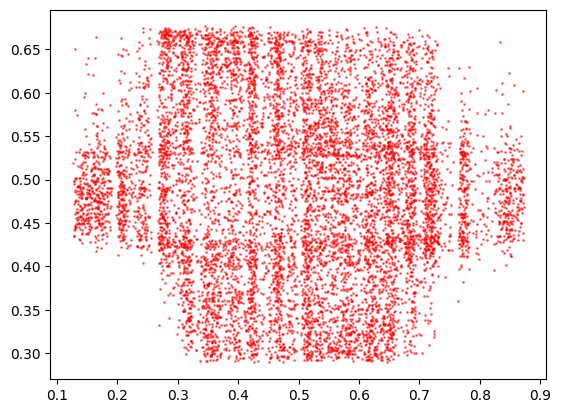

In [167]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as scs

# Assuming samples is a 2D array with shape (n_samples, 2)
# and log_pdf_samples is a 1D array with shape (n_samples,)

# Transform samples using the CDF
samples_cdf = igc_cop.forward(10000).detach().numpy()

fig, axs = plt.subplots(2, 2, figsize=(6, 6))

# Subplot [0,0]: Histogram of samples_cdf[:, 0]
axs[0, 0].hist(samples_cdf[:, 0], bins=30, color='blue', alpha=0.7,density=True)
axs[0, 0].set_title('Histogram of samples_cdf[:, 0]')
axs[0, 0].set_xlabel('samples_cdf[:, 0]')
axs[0, 0].set_ylabel('Frequency')

# Subplot [1,1]: Histogram of samples_cdf[:, 1] rotated 90 degrees clockwise
axs[1, 1].hist(samples_cdf[:, 1], bins=30, color='green', alpha=0.7, orientation='horizontal',density=True)
axs[1, 1].set_title('Histogram of samples_cdf[:, 1]')
axs[1, 1].set_xlabel('Frequency')
axs[1, 1].set_ylabel('samples_cdf[:, 1]')

# Subplot [1,0]: 2D scatter plot of samples_cdf with colors based on log_pdf_samples
sc = axs[1, 0].scatter(samples_cdf[:, 0], samples_cdf[:, 1], s=0.1, c='blue',alpha=0.3, marker='o',label='IGC simulated')
axs[1, 0].set_title('2D Scatter plot of samples_cdf')
axs[1, 0].set_xlabel('samples_cdf[:, 0]')
axs[1, 0].set_ylabel('samples_cdf[:, 1]')
axs[1, 0].legend()
#fig.colorbar(sc, ax=axs[1, 0], label='log_pdf_samples')

# Subplot [0,1]: Trace plot of samples_cdf
sc =axs[0, 1].scatter(u_obs[:,0], u_obs[:,1],label='observed', s=1, c='red',alpha=0.5)
axs[0, 1].set_title('2D Scatter plot of observed_cdf')
axs[0, 1].set_xlabel('observed_cdf[:, 0]')
axs[0, 1].set_ylabel('observed_cdf[:, 1]')
axs[0, 1].legend()

plt.tight_layout()
plt.show()
plt.scatter(inverted_cdf1(samples_cdf[:,0]),inverted_cdf2(samples_cdf[:,1]), s=1, c='red',alpha=0.5)